In [ ]:
!pip install scikit-learn

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve

In [8]:
# Load preprocessed data
df = pd.read_csv("preprocessed_smart_grid_data.csv")
X = df.drop(columns=["stab", "stabf"])
y = df["stabf"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Check if the model is already saved
if os.path.exists('xgb_untuned_model.pkl'):
    print("Loading saved XGBoost model...")
    xgb_model = joblib.load('xgb_untuned_model.pkl')
else:
    # Train if model isn't saved
    print("Training new XGBoost model...")
    xgb_model = xgb.XGBClassifier(eval_metric='logloss', objective='binary:logistic', random_state=42)
    xgb_model.fit(X_train, y_train)
    joblib.dump(xgb_model, 'xgb_untuned_model.pkl')

# Prediction
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
print("===== XGBoost Untuned Results =====")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Classification Report:\n", classification_report(y_test, xgb_pred))

Training new XGBoost model...
===== XGBoost Untuned Results =====
Accuracy: 0.9791666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      7678
           1       0.98      0.97      0.97      4322

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



In [10]:
# Check if the model is already saved
if os.path.exists('rf_untuned_model.pkl'):
    print("Loading saved Random Forest model...")
    rf_model = joblib.load('rf_untuned_model.pkl')
else:
    # Train if model isn't saved
    print("Training new Random Forest model...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    joblib.dump(rf_model, 'rf_untuned_model.pkl')

# Prediction
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
print("\n===== Random Forest Untuned Results =====")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Classification Report:\n", classification_report(y_test, rf_pred))

Training new Random Forest model...

===== Random Forest Untuned Results =====
Accuracy: 0.94725
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      7678
           1       0.94      0.91      0.93      4322

    accuracy                           0.95     12000
   macro avg       0.95      0.94      0.94     12000
weighted avg       0.95      0.95      0.95     12000



<Figure size 1000x600 with 0 Axes>

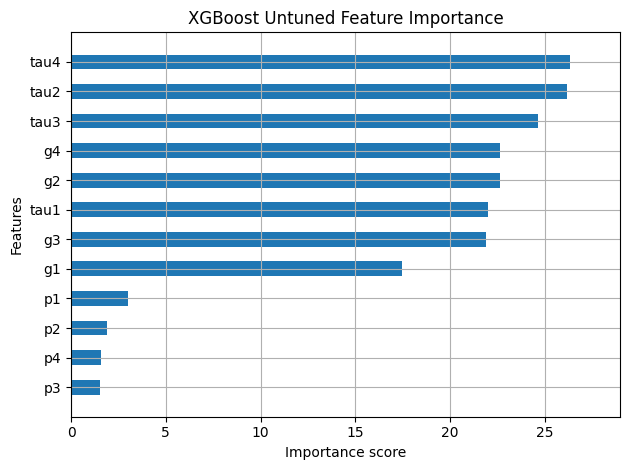

In [11]:
# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='gain', show_values=False, height=0.5)
plt.title("XGBoost Untuned Feature Importance")
plt.tight_layout()
plt.show()

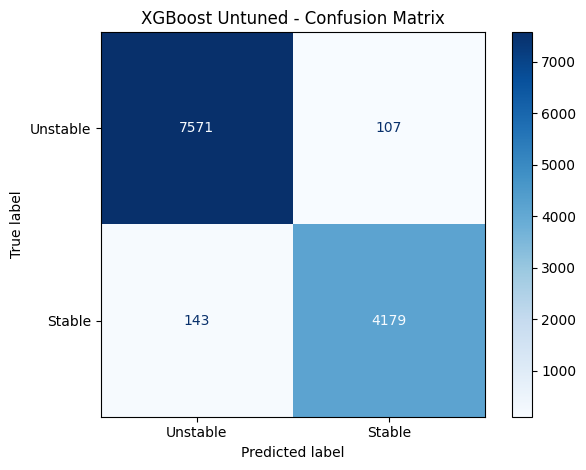

In [12]:
# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_pred)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Unstable", "Stable"])
disp_xgb.plot(cmap="Blues")
plt.title("XGBoost Untuned - Confusion Matrix")
plt.tight_layout()
plt.show()

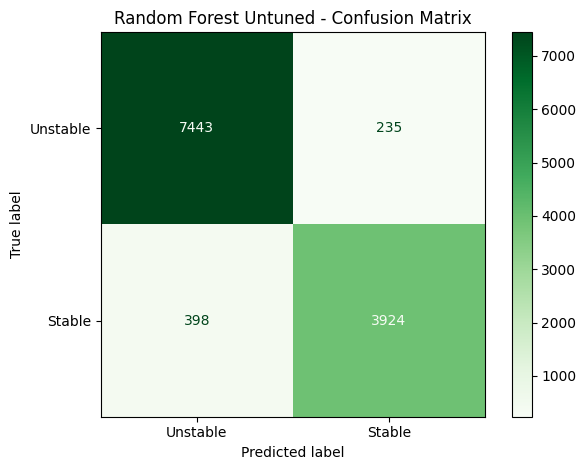

In [13]:
# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Unstable", "Stable"])
disp_rf.plot(cmap="Greens")
plt.title("Random Forest Untuned - Confusion Matrix")
plt.tight_layout()
plt.show()

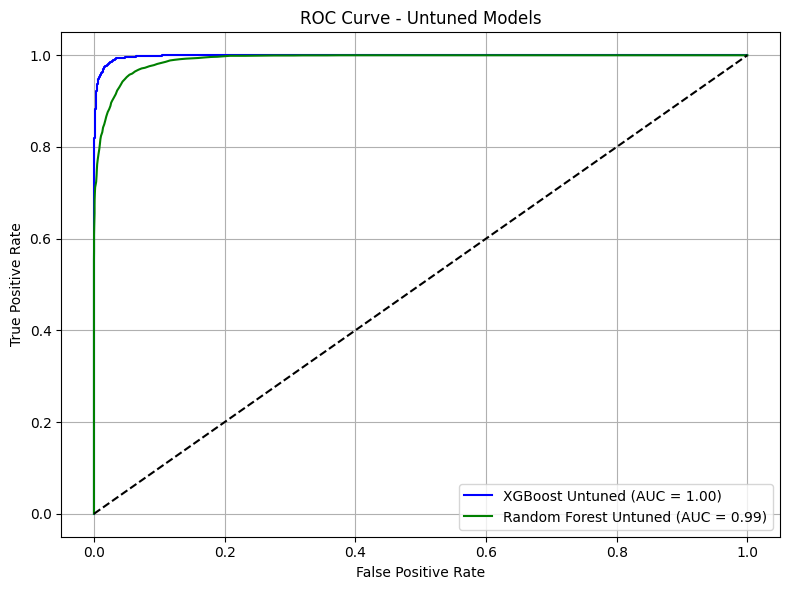

In [14]:
# ROC Curve for both models
fpr_xgb_untuned, tpr_xgb_untuned, _ = roc_curve(y_test, xgb_proba)
roc_auc_xgb_untuned = auc(fpr_xgb_untuned, tpr_xgb_untuned)

fpr_rf_untuned, tpr_rf_untuned, _ = roc_curve(y_test, rf_proba)
roc_auc_rf_untuned = auc(fpr_rf_untuned, tpr_rf_untuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_untuned, tpr_xgb_untuned, label=f"XGBoost Untuned (AUC = {roc_auc_xgb_untuned:.2f})", color="blue")
plt.plot(fpr_rf_untuned, tpr_rf_untuned, label=f"Random Forest Untuned (AUC = {roc_auc_rf_untuned:.2f})", color="green")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Untuned Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Function to get model metrics
def get_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1)
    rec = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return pd.Series({'Model': model_name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1})

# Get metrics for untuned models
rf_metrics_untuned = get_metrics(y_test, rf_pred, 'Random Forest (Untuned)')
xgb_metrics_untuned = get_metrics(y_test, xgb_pred, 'XGBoost (Untuned)')

# Comparison DataFrame
comparison_df_untuned = pd.DataFrame([rf_metrics_untuned, xgb_metrics_untuned])

# Display comparison
print("\n--- Untuned Model Comparison ---")
print(comparison_df_untuned)


--- Untuned Model Comparison ---
                     Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest (Untuned)  0.947250   0.943496  0.907913  0.925363
1        XGBoost (Untuned)  0.979167   0.975035  0.966913  0.970957


In [16]:
# Check if tuned models already exist
if os.path.exists('best_rf_model.pkl') and os.path.exists('best_xgb_model.pkl'):
    print("Loading saved tuned models...")
    best_rf = joblib.load('best_rf_model.pkl')
    best_xgb = joblib.load('best_xgb_model.pkl')
else:
    # Random Forest Tuning
    rf_params = {
        'n_estimators': [100, 300, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    rf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    best_rf = rf_random.best_estimator_

    # XGBoost Tuning
    xgb_params = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, None],
        'subsample': [0.7, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.9, 1.0]
    }

    xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)
    xgb_random = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    xgb_random.fit(X_train, y_train)
    best_xgb = xgb_random.best_estimator_

    # Save tuned models
    joblib.dump(best_rf, 'best_rf_model.pkl')
    joblib.dump(best_xgb, 'best_xgb_model.pkl')


c:\Users\THENMOZHI S\Desktop\ThennCUDA\cuda\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

print("\n--- XGBoost ---")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


--- Random Forest ---
Accuracy: 0.9506666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      7678
           1       0.95      0.92      0.93      4322

    accuracy                           0.95     12000
   macro avg       0.95      0.94      0.95     12000
weighted avg       0.95      0.95      0.95     12000


--- XGBoost ---
Accuracy: 0.99275
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7678
           1       0.99      0.99      0.99      4322

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



In [18]:
print("\n--- Cross-Validation ---")
cv_train_rf = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
cv_test_rf = cross_val_score(best_rf, X_test, y_test, cv=5, scoring='accuracy')

cv_train_xgb = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='accuracy')
cv_test_xgb = cross_val_score(best_xgb, X_test, y_test, cv=5, scoring='accuracy')

print(f"Random Forest - Train CV: {cv_train_rf.mean():.4f} ± {cv_train_rf.std():.4f}")
print(f"Random Forest - Test CV: {cv_test_rf.mean():.4f} ± {cv_test_rf.std():.4f}")
print(f"XGBoost - Train CV: {cv_train_xgb.mean():.4f} ± {cv_train_xgb.std():.4f}")
print(f"XGBoost - Test CV: {cv_test_xgb.mean():.4f} ± {cv_test_xgb.std():.4f}")


--- Cross-Validation ---
Random Forest - Train CV: 0.9457 ± 0.0017
Random Forest - Test CV: 0.9273 ± 0.0021
XGBoost - Train CV: 0.9877 ± 0.0011
XGBoost - Test CV: 0.9633 ± 0.0023


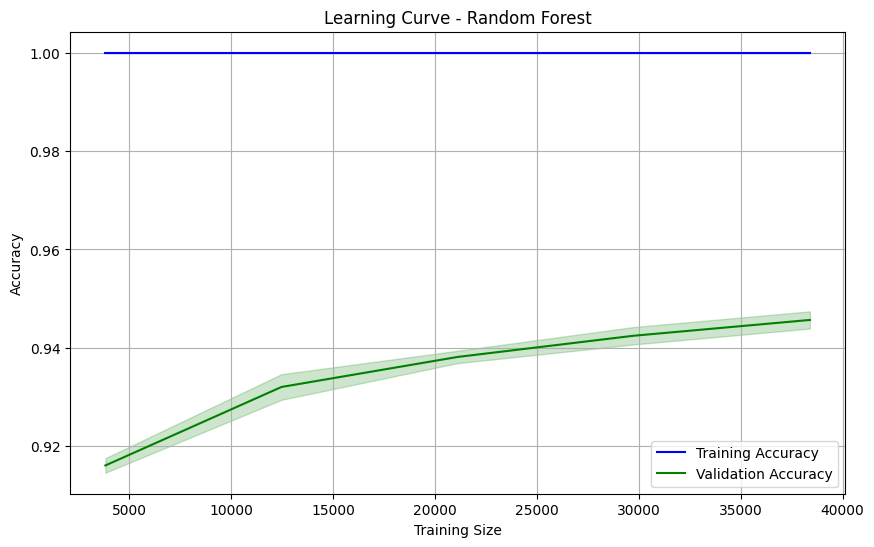

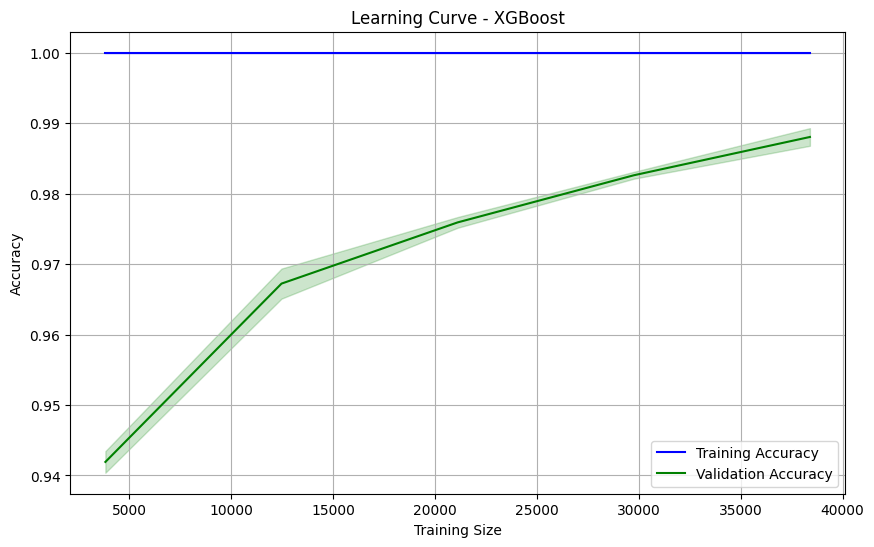

In [19]:
def plot_learning_curve(model, model_name):
    train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

    train_mean = train_scores.mean(axis=1)
    valid_mean = valid_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    valid_std = valid_scores.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
    plt.plot(train_sizes, valid_mean, label='Validation Accuracy', color='green')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='green')
    plt.title(f"Learning Curve - {model_name}")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot learning curves for Random Forest and XGBoost
plot_learning_curve(best_rf, "Random Forest")
plot_learning_curve(best_xgb, "XGBoost")

C:\Users\THENMOZHI S\AppData\Local\Temp\ipykernel_10400\887062923.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance, palette='Greens')


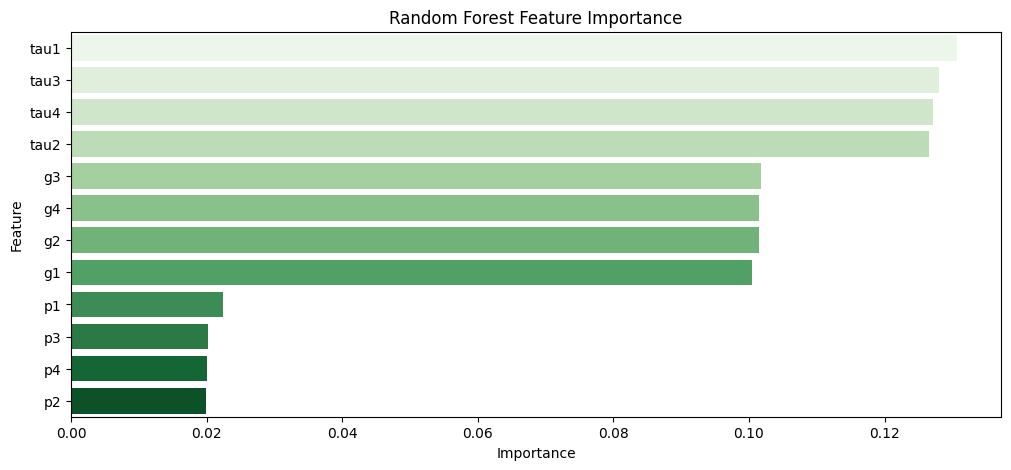

C:\Users\THENMOZHI S\AppData\Local\Temp\ipykernel_10400\887062923.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_importance, palette='Blues')


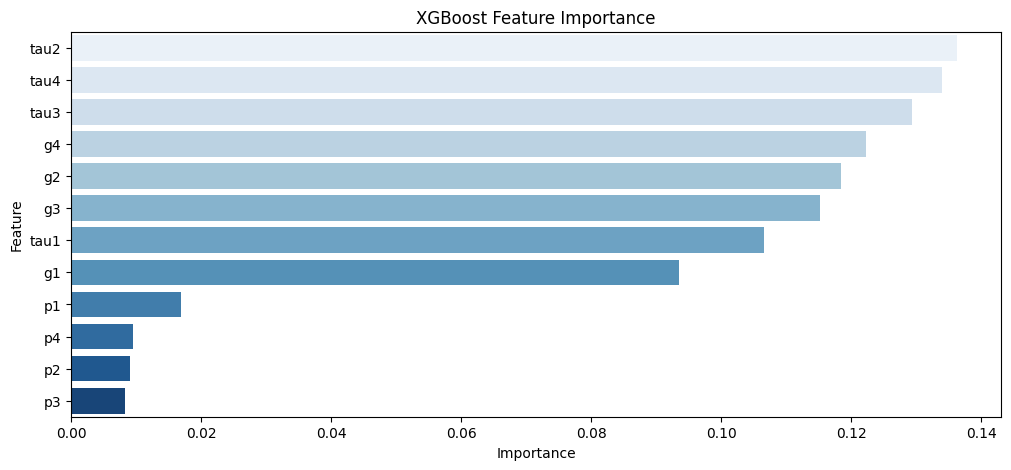

In [20]:
rf_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_}).sort_values(by='Importance', ascending=False)
xgb_importance = pd.DataFrame({'Feature': X.columns, 'Importance': best_xgb.feature_importances_}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x='Importance', y='Feature', data=rf_importance, palette='Greens')
plt.title("Random Forest Feature Importance")
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x='Importance', y='Feature', data=xgb_importance, palette='Blues')
plt.title("XGBoost Feature Importance")
plt.show()

In [21]:
# Confusion Matrix
def plot_conf_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# ROC Curve
def plot_roc(model, model_name, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)  # No mapping needed
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Precision-Recall Curve
def plot_pr_curve(model, model_name, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)  # No mapping needed
    plt.figure()
    plt.plot(recall, precision, color='purple')
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()

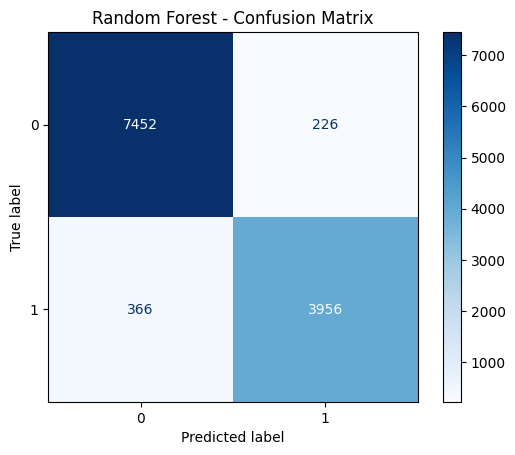

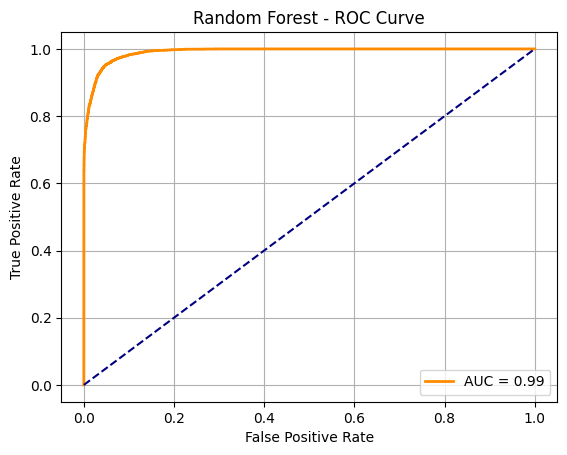

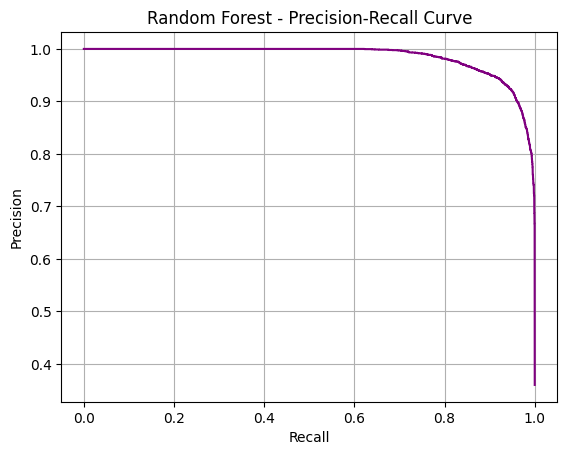

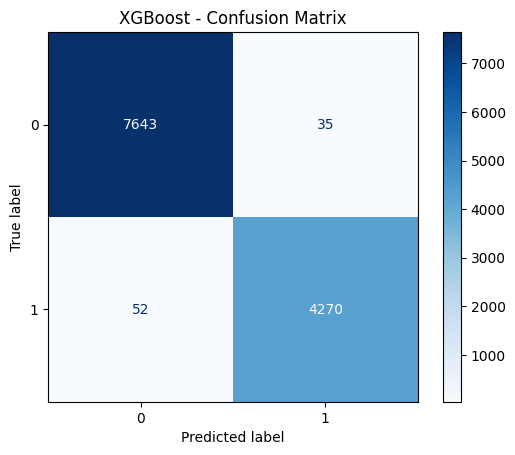

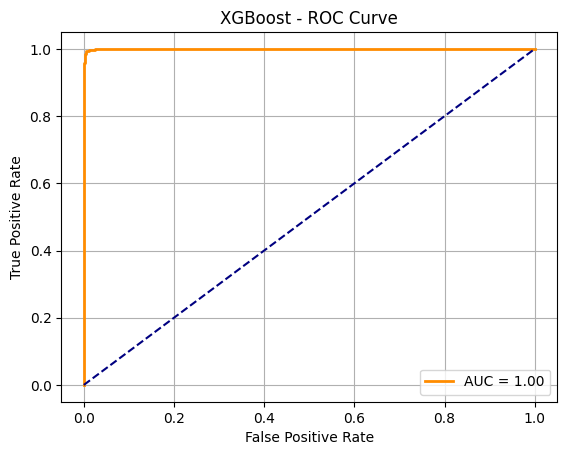

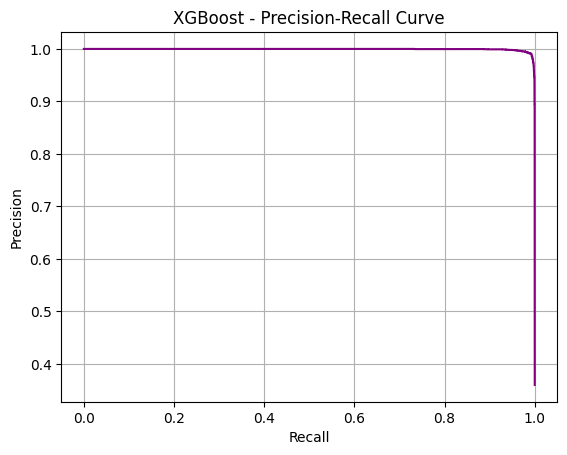

In [22]:
# Random Forest
plot_conf_matrix("Random Forest", y_test, y_pred_rf)
plot_roc(best_rf, "Random Forest", X_test, y_test)
plot_pr_curve(best_rf, "Random Forest", X_test, y_test)

# XGBoost
plot_conf_matrix("XGBoost", y_test, y_pred_xgb)
plot_roc(best_xgb, "XGBoost", X_test, y_test)
plot_pr_curve(best_xgb, "XGBoost", X_test, y_test)

In [23]:
def get_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=1)
    rec = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return pd.Series({'Model': model_name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1})

rf_metrics = get_metrics(y_test, y_pred_rf, 'Random Forest')
xgb_metrics = get_metrics(y_test, y_pred_xgb, 'XGBoost')

comparison_df = pd.DataFrame([rf_metrics, xgb_metrics])
print("\n--- Model Comparison ---")
print(comparison_df)


--- Model Comparison ---
           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.950667   0.945959  0.915317  0.930386
1        XGBoost  0.992750   0.991870  0.987969  0.989915


In [24]:
# Prediction for tuned models
y_pred_rf_tuned = best_rf.predict(X_test)
y_pred_xgb_tuned = best_xgb.predict(X_test)

# Get metrics for tuned models
rf_metrics_tuned = get_metrics(y_test, y_pred_rf_tuned, 'Random Forest (Tuned)')
xgb_metrics_tuned = get_metrics(y_test, y_pred_xgb_tuned, 'XGBoost (Tuned)')

# Combine with untuned metrics
comparison_df = pd.DataFrame([rf_metrics_untuned, xgb_metrics_untuned, rf_metrics_tuned, xgb_metrics_tuned])

# Display comparison
print("\n--- Full Model Comparison ---")
print(comparison_df)


--- Full Model Comparison ---
                     Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest (Untuned)  0.947250   0.943496  0.907913  0.925363
1        XGBoost (Untuned)  0.979167   0.975035  0.966913  0.970957
2    Random Forest (Tuned)  0.950667   0.945959  0.915317  0.930386
3          XGBoost (Tuned)  0.992750   0.991870  0.987969  0.989915
